### 1. Importing packages

In [ ]:
!pip install pandas-datareader==0.10.0

In [ ]:
!pip install 'ray[tune]'

In [ ]:
# data preprocessing
import datetime
import pandas as pd
import pandas_datareader.data as pdr
from sklearn.preprocessing import MinMaxScaler
import numpy
import seaborn as sns
import matplotlib.pyplot as plt


# machine learning
import torch
from torch.autograd import Variable
import torch.nn as nn

# hyperparameter tuning
import ray
from ray import tune

### 2. Loading datasets

In [ ]:
# loading sentiment scores
sentiment_scores_df = pd.read_csv('daily-avg-sentiment-scores.csv', index_col=0)
sentiment_scores_df = sentiment_scores_df.iloc[:, 1]
sentiment_scores_df = pd.DataFrame(sentiment_scores_df)
sentiment_scores_df.index = pd.to_datetime(sentiment_scores_df.index)
sentiment_scores_df.head()

,sentiment_score_final
date,
2020-01-01,0.154961
2020-01-02,0.161528
2020-01-03,0.128297
2020-01-04,0.144796
2020-01-05,0.132267


In [ ]:
start_time_all = datetime.datetime(2020, 1, 1) # 2020-01-01
end_time_train = datetime.datetime(2020, 9, 30) # 2020-09-30
start_time_val = datetime.datetime(2020, 10, 1) # 2020-10-01
end_time_all = datetime.datetime(2020, 12, 31) # 2020-12-31

# loading Tesla, Inc. (TSLA) stock price data from Yahoo Finance
tsla_price_df = pdr.DataReader('TSLA', 'yahoo', start_time_all, end_time_all)
tsla_price_df.index = pd.to_datetime(tsla_price_df.index)

In [ ]:
tsla_price_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001


In [ ]:
tsla_price_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,666.090027,641.000000,642.98999,661.770020,22865600.0,661.770020
2020-12-28,681.400024,660.799988,674.51001,663.690002,32278600.0,663.690002
2020-12-29,669.900024,655.000000,661.00000,665.989990,22910800.0,665.989990
2020-12-30,696.599976,668.359985,672.00000,694.780029,42846000.0,694.780029
2020-12-31,718.719971,691.119995,699.98999,705.669983,49649900.0,705.669983


In [ ]:
# adding daily returns to stock price data
tsla_price_df['Return'] = tsla_price_df['Adj Close'].pct_change()

In [ ]:
# adding sentiment scores to stock price data
tsla_price_df = pd.merge(tsla_price_df, sentiment_scores_df, left_index=True, right_index=True)
tsla_price_df = tsla_price_df.rename(columns={'sentiment_score_final': 'Sentiment Score'})

In [ ]:
tsla_price_df.head()

,High,Low,Open,Close,Volume,Adj Close,Return,Sentiment Score
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,NaN,0.161528
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,0.029633,0.128297
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,0.019255,0.117547
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,0.038801,0.104325
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001,0.049205,0.123884


In [ ]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

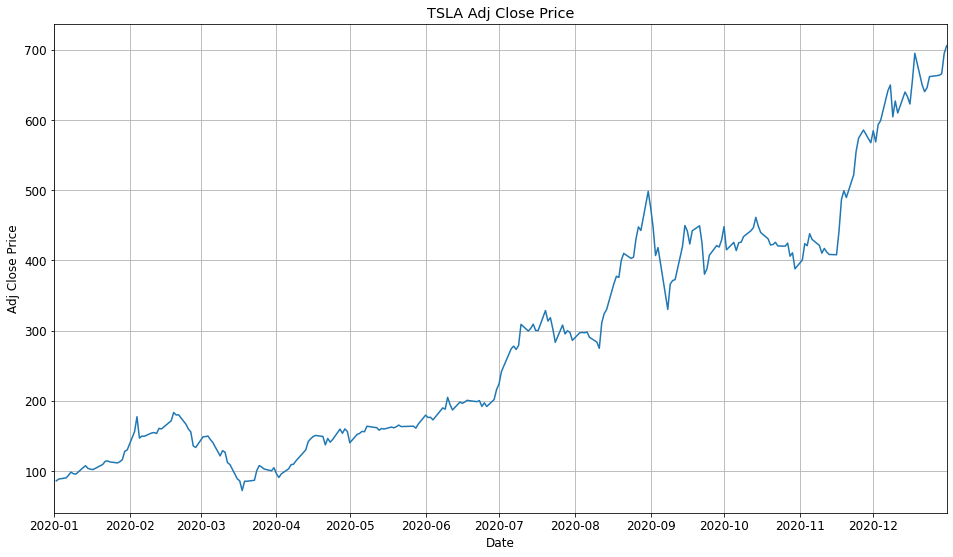

In [ ]:
# plotting TSLA Adj Close price from 2020-01-01 to 2020-12-31
plt.plot(tsla_price_df.index, tsla_price_df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('TSLA Adj Close Price')
plt.show()

In [ ]:
# calculating correlation between daily returns and sentiment scores
tsla_price_df['Return'][1:].corr(tsla_price_df['Sentiment Score'][1:])

0.00929172597567596

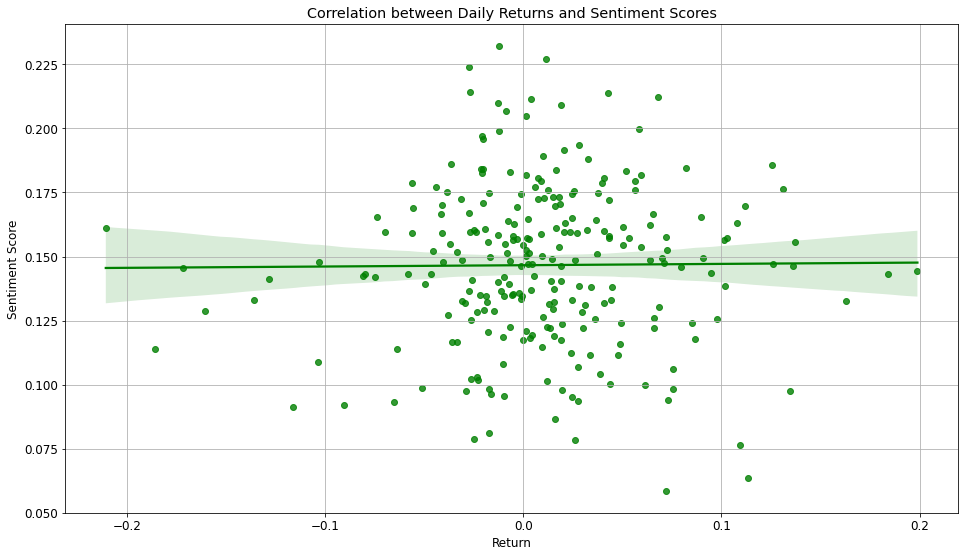

In [ ]:
# plotting correlation between daily returns and sentiment scores
sns.regplot(x=tsla_price_df['Return'][1:], y=tsla_price_df['Sentiment Score'][1:], color='g')
plt.title('Correlation between Daily Returns and Sentiment Scores')
plt.show()

In [ ]:
# features (High price, Low price, Open price, Close price, Volume, Sentiment Score)
X = tsla_price_df.drop(['Adj Close', 'Return'], axis=1)
# response (Adj Close price)
y = tsla_price_df.iloc[:, 5:6]

### 3. Normalizing and converting data

In [ ]:
n_split = 189 # where to split training and validation datasets

In [ ]:
# normalizing datasets
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
y_norm = scaler.fit_transform(y)

# training using Jan - Sep data
# validating trained model using Oct - Dec data
X_train = X_norm[:n_split, :]
y_train = y_norm[:n_split, :]

print('Training Set Shape ', X_train.shape, y_train.shape)

Training Set Shape  (189, 6) (189, 1)


In [ ]:
# converting data to tensors
X_train_tensors = Variable(torch.Tensor(X_train))
y_train_tensors = Variable(torch.Tensor(y_train))

X_val_tensors = Variable(torch.Tensor(X_norm))
y_true = numpy.array(y)

# reshaping X dataset
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 
                                                  1, X_train_tensors.shape[1]))
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0], 
                                              1, X_val_tensors.shape[1]))

print('Training Set Shape   ', X_train_tensors.shape, y_train_tensors.shape)
print('Validation Set Shape ', X_val_tensors.shape, y_true.shape)

Training Set Shape    torch.Size([189, 1, 6]) torch.Size([189, 1])
Validation Set Shape  torch.Size([253, 1, 6]) (253, 1)


### 4. Building LSTM model

In [ ]:
# selecting gpu
device = torch.device('cuda')

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

### 5. Hyperparameter tuning

In [ ]:
# starting ray runtime
ray.init()

{'gcs_address': '172.28.0.2:36179',
 'metrics_export_port': 57079,
 'node_id': '1ffec42a5ac7870e01f4419e322abaa8a6db7984dc72985172b02012',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2022-02-05_08-06-09_955755_80/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2022-02-05_08-06-09_955755_80/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2022-02-05_08-06-09_955755_80',
 'webui_url': None}

In [ ]:
# checking available resources
ray.cluster_resources()

{'CPU': 2.0,
 'GPU': 1.0,
 'accelerator_type:T4': 1.0,
 'memory': 6668400231.0,
 'node:172.28.0.2': 1.0,
 'object_store_memory': 3334200115.0}

In [ ]:
# function for calculating MSE (Mean Squared Error)
def calc_mse(y_true, y_hat):
    mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))
    return mse

In [ ]:
# function for fitting and evaluating model using different hyperparameters
def model_fit_eval(config=None, best_config=None, save_model_state=False):
    if best_config is None:
        hidden_size = config['hidden_size']
        num_layers = config['num_layers']
        learning_rate = config['learning_rate']
        # learning rate controls how much to change model in response to estm error each time model weights are updated
        num_epochs = config['num_epochs']
    else:
        hidden_size = best_config['hidden_size']
        num_layers = best_config['num_layers']
        learning_rate = best_config['learning_rate']
        num_epochs = best_config['num_epochs']

    input_size = 6
    num_classes = 1
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train_tensors.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train_tensors.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop
        if best_config is not None:
            if epoch % 1000 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    
    # saving model state
    if save_model_state:
        torch.save(model.state_dict(), '4-model-state.pth')

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()
    
    # predicting response from model
    y_hat = model(X_val_tensors.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation

    if best_config is None:
        mse = calc_mse(y_true, y_hat)
        tune.report(mse=mse)
    else:
        return y_hat

In [ ]:
# using grid search to get best hyperparameters
analysis = tune.run(
    model_fit_eval, 
    config={'hidden_size': tune.grid_search([2, 3, 5]), 
            'learning_rate': tune.grid_search([0.0005, 0.001, 0.002]), 
            'num_epochs': tune.grid_search([2000, 4000, 8000]), 
            'num_layers': tune.grid_search([1, 2, 4])}, 
    resources_per_trial={'cpu': 2, 'gpu': 1}) # leveraging all resources

In [ ]:
# visualizing hyperparameter tuning results
%load_ext tensorboard
%tensorboard --logdir ~/ray_results

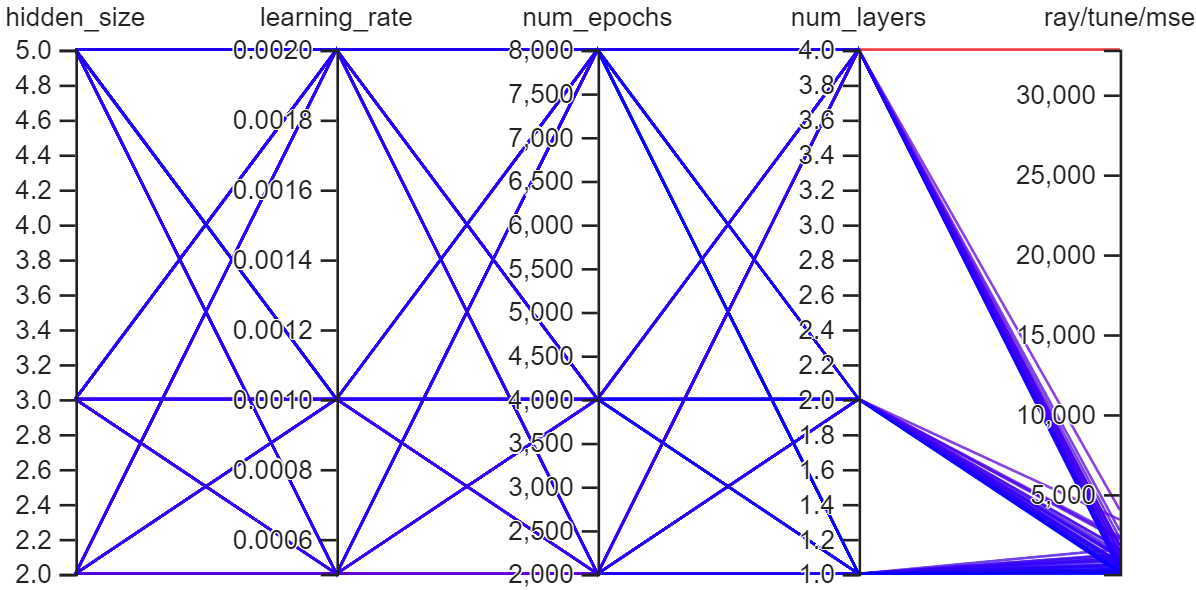

In [ ]:
# best hyperparameters
best_trial = analysis.get_best_trial(metric='mse', mode='min', scope='all')
min_mse = best_trial.metric_analysis['mse']['avg']
print(f'Min MSE: {min_mse}')
best_trial_config = best_trial.config
print(f'Best trial config: {best_trial_config}')

Min MSE: 12.741239547729492
Best trial config: {'hidden_size': 5, 'learning_rate': 0.002, 'num_epochs': 8000, 'num_layers': 1}


In [ ]:
# training model using best hyperparameters
best_trial_config['num_epochs'] = 10000 # increasing num of epochs
y_hat = model_fit_eval(best_config=best_trial_config, save_model_state=True)

Epoch: 0, Loss: 0.0293
Epoch: 1000, Loss: 0.0001
Epoch: 2000, Loss: 0.0000
Epoch: 3000, Loss: 0.0000
Epoch: 4000, Loss: 0.0000
Epoch: 5000, Loss: 0.0000
Epoch: 6000, Loss: 0.0000
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000


In [ ]:
# shutting down ray runtime
ray.shutdown()

### 6. Results

In [ ]:
# function for plotting actual and predicted Adj Close price
def plt_graph(start_time, end_time, period, val_line=False):
    # plotting actual Adj Close price
    plt.plot(tsla_price_df.index, y_true, label='Actual Price')
    # plotting predicted Adj Close price
    plt.plot(tsla_price_df.index, y_hat, label='Pred Price')
    if val_line:
        plt.axvline(x=start_time_val, c='r', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.xlim(start_time, end_time)
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

#### All period

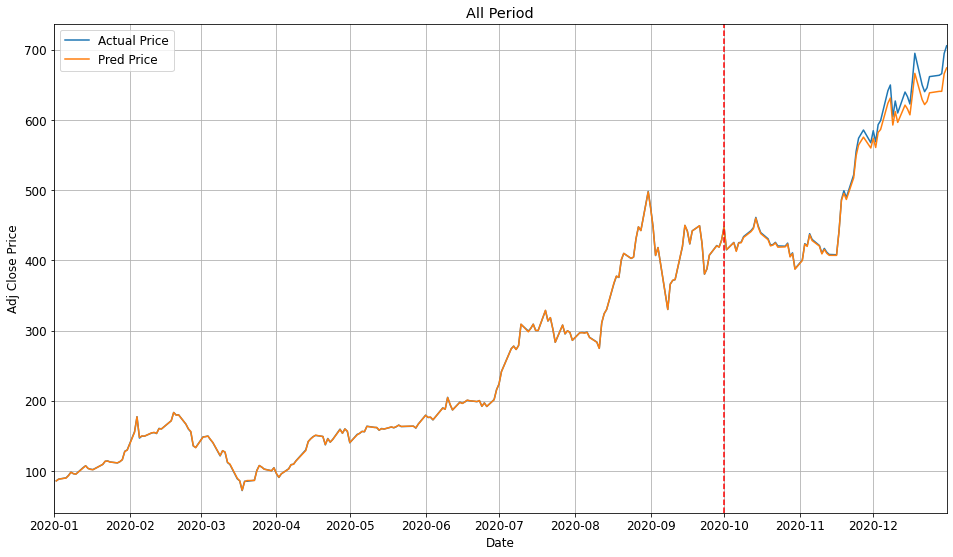

In [ ]:
# plotting all period
period = 'All'
plt_graph(start_time_all, end_time_all, period, True)

In [ ]:
mse = calc_mse(y_true, y_hat)
print(f'MSE ({period}): {mse}')

MSE (All): 35.028627722561374


#### Training period

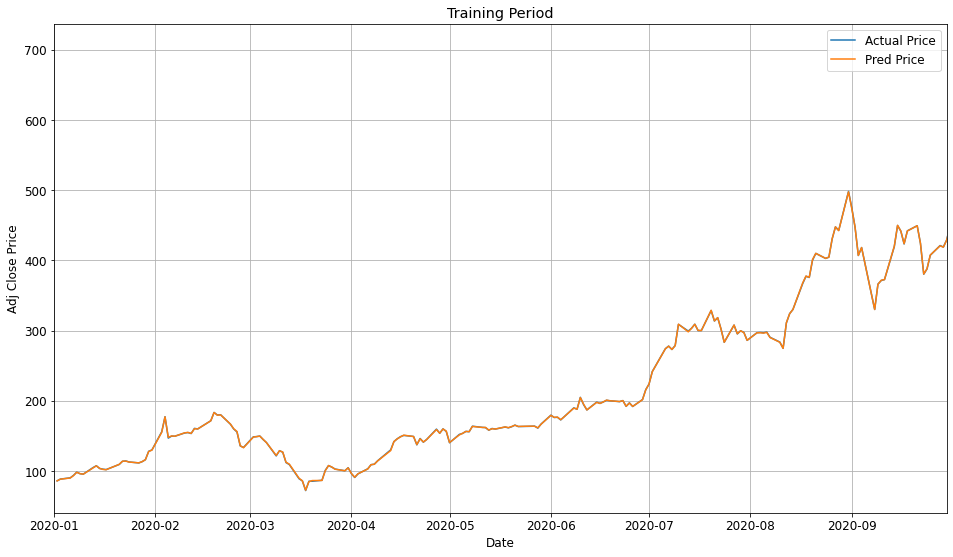

In [ ]:
# plotting training period
period = 'Training'
plt_graph(start_time_all, end_time_train, period)

In [ ]:
mse = calc_mse(y_true[:n_split], y_hat[:n_split])
print(f'MSE ({period}): {mse}')

MSE (Training): 0.11838243676105603


#### Validation period

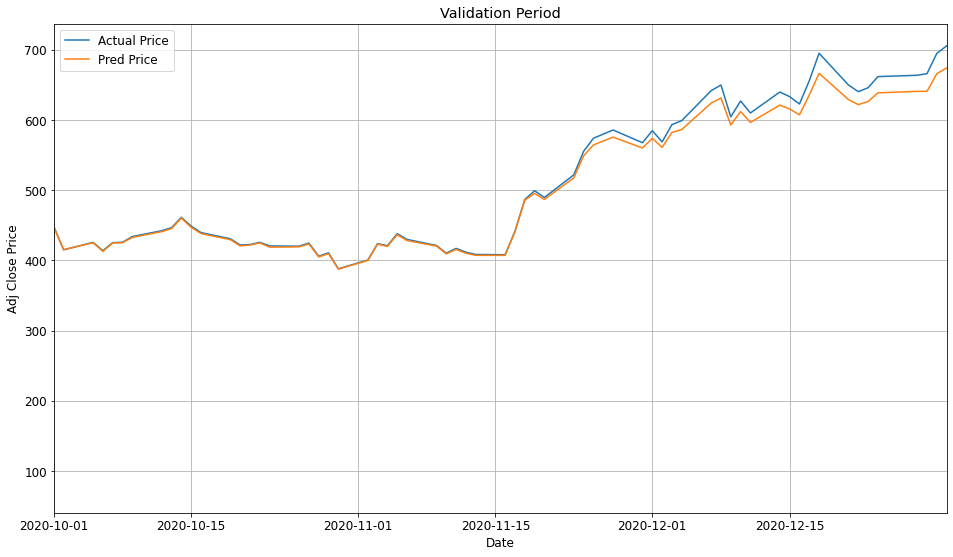

In [ ]:
# plotting validation period
period = 'Validation'
plt_graph(start_time_val, end_time_all, period)

In [ ]:
mse = calc_mse(y_true[n_split:], y_hat[n_split:])
print(f'MSE ({period}): {mse}')

MSE (Validation): 138.12294583219045
